# Auswertung und Visualisierung

In [48]:
import sqlite3
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter, defaultdict
from statistics import median
import json
from urllib.parse import urlparse, urlunsplit, urlsplit
from tldextract import extract

In [2]:
con = sqlite3.connect("berlinerkultuerbedaten.db")
cur = con.cursor()

## Gesamtzahl der Datensätze

In [3]:
rows = cur.execute("SELECT COUNT(OBJID) FROM objects;").fetchone()

In [4]:
gesamtzahl = rows[0]

## Anteil der Institutionen

In [5]:
rows = cur.execute("SELECT COUNT(OBJID), INSTID FROM objects GROUP BY INSTID;").fetchall()

In [6]:
rows = { _[1] : _[0] for _ in rows}

In [7]:
inst = []
for k,v in rows.items():
    inst.append((k,v,v/sum(rows.values())*100))
    
for _ in sorted(inst, key = lambda x:x[2], reverse = True):
    print(_)


('FKBVHZEFB6RYNEMU3RNQGTMCFOSV7463', 634334, 53.17454196732745)
('LW73ONMGOBSW6QNG335MQE2CHIHR46OA', 160649, 13.466780895410285)
('VH3B3BVEVLGX2XZA5SRAL2CYJOW6YV76', 108941, 9.132235977359908)
('VFCOJS5WO2NGUS2EE5RFORXDF2PPEUW3', 70400, 5.901445854234287)
('R7K5YPOMO6QRPENPN6PZBNSG2WOUTHBB', 36339, 3.046202285469031)
('GYOFNDWZZGF3HOE7OUDXSJZOJ5SR4EHA', 30751, 2.577775020789184)
('5OIP5QTSEBITZZF4BUOVT7FT4TCXMEBY', 19149, 1.605210037822903)
('6GWXTQXD535KAX63RWUKGWHAQ6GTKJF3', 14054, 1.1781096595938731)
('YOLD7CGUQOZCU3BV6SLNB5QAE2XP7Z6O', 13417, 1.124711633895759)
('J7PU7VXCKLYH3XGYD3AJBZ3L2KK4YXND', 12565, 1.0532907266825826)
('TABM2NBZHZYYQ4VS6B33U6UVBF7O6UQ4', 12526, 1.0500214598031063)
('HVSPX7GJEILJH3XAWHKZQ66MSGOK6IJC', 10525, 0.8822829206792027)
('LHTKWAUVEPKN5RMOIXDQL7UQMMRVZ52N', 10124, 0.8486681509697148)
('BVHG7TDOPHHYDMCBOXXVHQYGTZPYGDOD', 9582, 0.8032337240805815)
('4GPBA4AQV5TMM5VUM7SLABKLJCMJE6IA', 6503, 0.5451292953137155)
('4A757ENGAUSSJNGVFN5FHSZFNESEZSQA', 5871, 0.4

## Access

<BarContainer object of 2 artists>

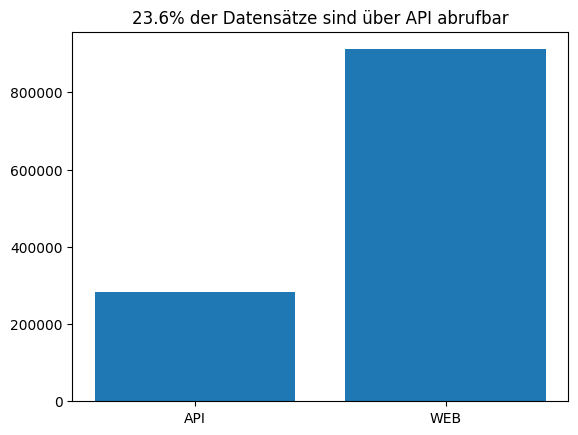

In [9]:
rows = cur.execute("SELECT ACCESS, COUNT(ACCESS) FROM objects GROUP BY ACCESS;").fetchall()
rows = { _[0] : _[1] for _ in rows}

api = rows.get('API') / sum(rows.values()) * 100

title = f"{api:.1f}% der Datensätze sind über API abrufbar"

plt.title(title)
plt.bar(rows.keys(),rows.values())

## Verteilung der Dateiformate

99.46778011749242


<BarContainer object of 3 artists>

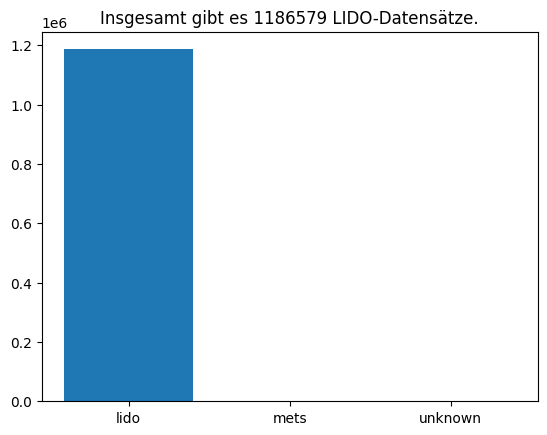

In [10]:
rows = cur.execute("SELECT FORMAT, COUNT(FORMAT) FROM analysis GROUP BY FORMAT;").fetchall()
xs,ys = zip(*rows)
rows = { _[0] : _[1] for _ in rows}
anteilLIDO = rows.get('lido')/gesamtzahl * 100
print(anteilLIDO)
title = f"Insgesamt gibt es {rows.get('lido')} LIDO-Datensätze."
plt.title(title)
plt.bar(xs,ys)

## Schemavalidität

<BarContainer object of 2 artists>

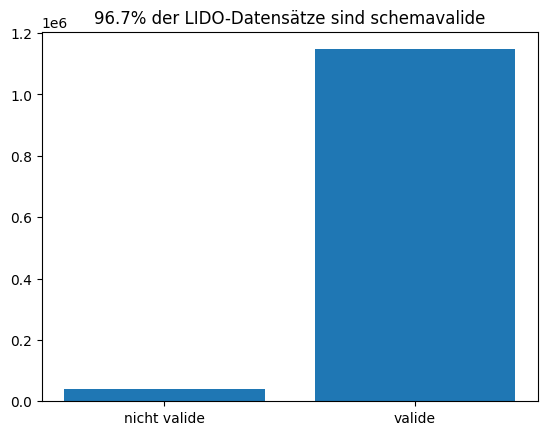

In [11]:
rows = cur.execute("select VALID, COUNT(VALID) from analysis WHERE FORMAT = 'lido' GROUP BY VALID;").fetchall()
rows = { _[0] : _[1] for _ in rows}

xMap = { 0 : "nicht valide", 1 : "valide"}

rows = { xMap.get(k) : v for k,v in rows.items() }
xs = rows.keys()
ys = rows.values()

valid = rows.get('valide') / sum(rows.values()) * 100

title = f"{valid:.1f}% der LIDO-Datensätze sind schemavalide"
plt.title(title)
plt.bar(xs,ys)

## Metadatenlizenzierung

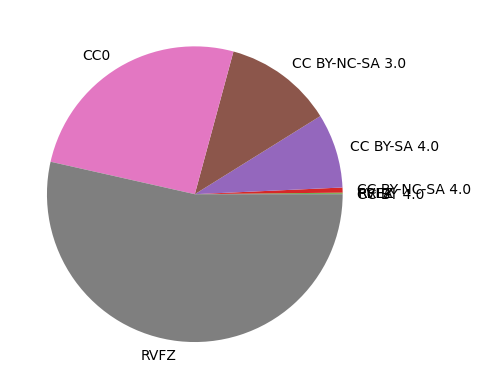

In [12]:
rows = cur.execute("SELECT LICENSE, COUNT(LICENSE) FROM analysis GROUP BY LICENSE;").fetchall()
rows = [ r for r in rows if r[0] is not None and r[1] > 0]
xs,ys = zip(*sorted(rows, key = lambda x:x[1]))
plt.pie(ys, labels= xs)
plt.show()

## Alter der Metadaten

Text(0.5, 1.0, 'Alter in Tagen (Median 1129)')

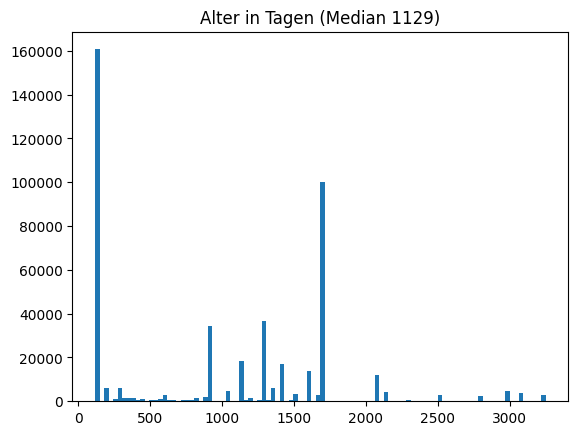

In [13]:
rows = cur.execute("SELECT AGE FROM analysis;").fetchall()
numberInDays = [r[0] for r in rows if r[0] is not None]
plt.hist(numberInDays, bins = 100)
MEDIAN = median(numberInDays)
title = f"Alter in Tagen (Median {MEDIAN})"
plt.title(title)

## Normdatenabdeckung

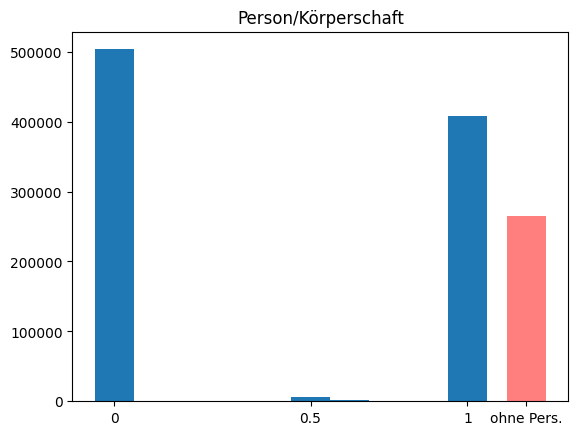

In [14]:
rows = cur.execute("SELECT ACTORCOV FROM analysis;").fetchall()
fig, ax = plt.subplots(1)
plt.hist([r[0] for r in rows if r[0] is not None])
c = Counter([r[0] for r in rows]).get(None)
ax.bar([1.1],[c],width=0.1, color='red', alpha=0.5)
ax.set_xticks([0.05,0.55,0.95,1.1], labels = ["0","0.5","1","ohne Pers."])
plt.title("Person/Körperschaft")
plt.savefig("nda_actor.png", dpi = 200)

In [55]:
c = Counter(rows)
c.pop((None,))
c.get((1.0,))/sum(c.values())

0.442753143613501

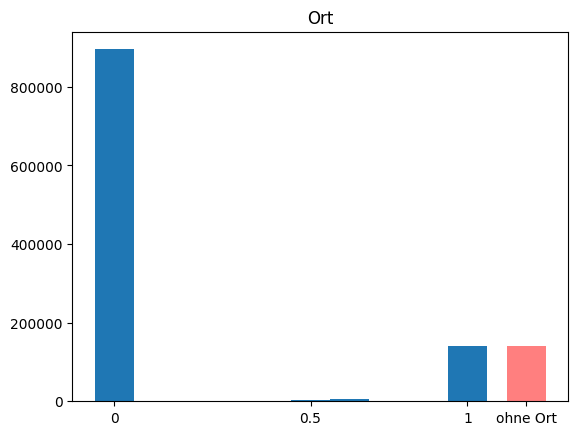

In [57]:
rows = cur.execute("SELECT PLACECOV FROM analysis;").fetchall()
fig, ax = plt.subplots(1)
plt.hist([r[0] for r in rows if r[0] is not None])
c = Counter([r[0] for r in rows]).get(None)
ax.bar([1.1],[c],width=0.1, color='red', alpha=0.5)
ax.set_xticks([0.05,0.55,0.95,1.1], labels = ["0","0.5","1","ohne Ort"])
plt.title("Ort")
plt.savefig("nda_place.png", dpi = 200)

In [58]:
c = Counter(rows)
c.pop((None,))
c.get((1.0,))/sum(c.values())

0.13536873843990277

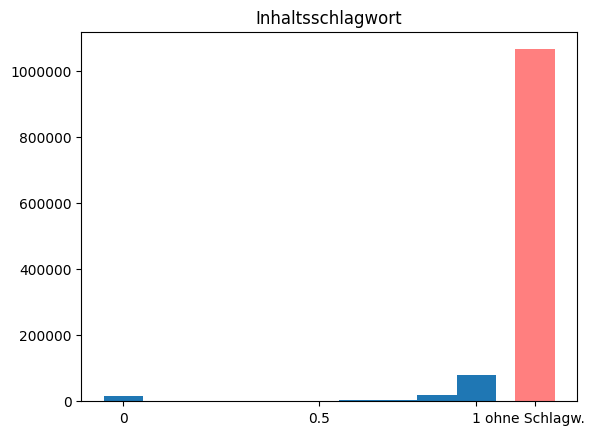

In [59]:
rows = cur.execute("SELECT SUBJECTCOV FROM analysis;").fetchall()
fig, ax = plt.subplots(1)
plt.hist([r[0] for r in rows if r[0] is not None])
c = Counter([r[0] for r in rows]).get(None)
ax.bar([1.1],[c],width=0.1, color='red', alpha=0.5)
ax.set_xticks([0.05,0.55,0.95,1.1], labels = ["0","0.5","1","ohne Schlagw."])
ax.ticklabel_format(axis = 'y', style = 'plain')
plt.title("Inhaltsschlagwort")
plt.savefig("nda_subject.png", dpi = 200)

In [60]:
c = Counter(rows)
c.pop((None,))
c.get((1.0,))/sum(c.values())

0.6351688853325574

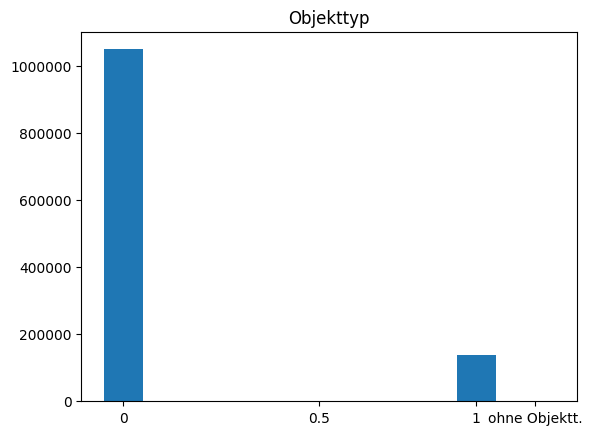

In [61]:
rows = cur.execute("SELECT OBJTYPECOV FROM analysis;").fetchall()
fig, ax = plt.subplots(1)
plt.hist([r[0] for r in rows if r[0] is not None])
c = Counter([r[0] for r in rows]).get(None)
ax.bar([1.1],[c],width=0.1, color='red', alpha=0.5)
ax.set_xticks([0.05,0.55,0.95,1.1], labels = ["0","0.5","1","ohne Objektt."])
ax.ticklabel_format(axis = 'y', style = 'plain')
plt.title("Objekttyp")
plt.savefig("nda_objecttype.png", dpi = 200)

In [62]:
c = Counter(rows)
c.pop((None,))
c.get((1.0,))/sum(c.values())

0.11594022132571254

## Ein näherer Blick auf die URIs

In [8]:
IN = open('URIs.json')
URIs = json.load(IN)

In [30]:
def validURI(uri:str) -> bool:
    '''Funktion überprüft, ob übergebener String ein URI ist'''
    
    parsed = urlparse(uri)
    if isinstance(uri, str) and all([parsed.scheme != "",parsed.netloc != ""]):
        return True
    else:
        return False
    
def atLeastOneURI(nestedurilist: list):
    counter = []
    for urilist in nestedurilist:
        if len(urilist) > 0:
            if (any([validURI(uri) for uri in urilist])):
                counter.append(True)
            else:
                counter.append(False)
    return Counter(counter)

def countNetloc(nestedurilist: list):
    basisURLs = []
    for urilist in nestedurilist:
        for uri in urilist:
            if validURI(uri):
                basisURL = uri.rpartition('/')[0].partition('//')[2]
                basisURLs.append(basisURL)
    return Counter(basisURLs)
                

def countTLD(nestedurilist: list):
    tldomains = []
    for urilist in nestedurilist:
        for uri in urilist:
            if validURI(uri):
                try:
                    TLD = extract(uri).domain
                    tldomains.append(TLD)
                except TypeError as e:
                    print(e)
    return Counter(tldomains)

titleMap = {
    'actor' : "Person/Körperschaft",
    'place' : "Ort",
    'subject' : "Inhaltsschlagwort",
    'objectType' : "Objekttyp"
}

In [33]:
# Anteil der URI-Listen mit wenigstens einem gültigen URI
for k,v in URIs.items():
    print(k)
    c = atLeastOneURI(v)
    perc = c.get(True)/sum(c.values()) * 100
    print(perc)

actor
65.47890440149548
place
69.58341322155593
subject
87.02275911338732
objectType
87.07457284679172


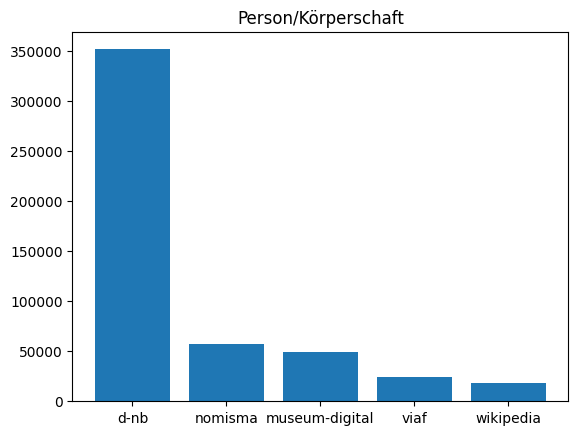

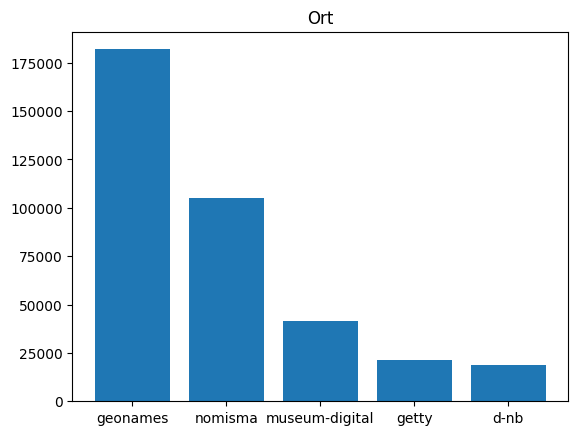

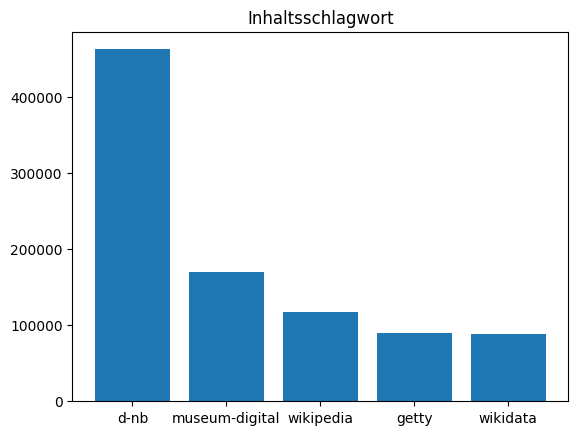

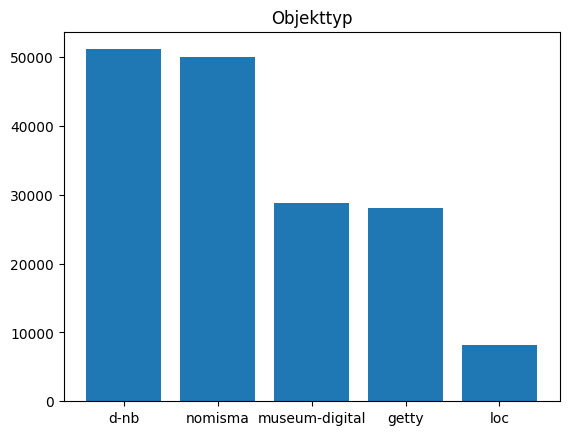

In [32]:
# Am häufigsten verwendete URIs
for k,v in URIs.items():
    
    c = countTLD(v).most_common(5)
    xs,ys = zip(*c)
    plt.title(titleMap.get(k))
    plt.bar(xs,ys)
    plt.savefig(f"voc_{k}.png", dpi = 200)
    plt.show()

In [36]:
# URI-Variationen

allURIs = []
for nestedUriList in URIs.values():
    for urilist in nestedUriList:
        allURIs.extend(urilist)

In [49]:
uriVarianten = defaultdict(list)
for uri in allURIs:
    if validURI(uri):
        tld = extract(uri).domain
        _ = urlsplit(uri)._replace(path='', query='', fragment='')
        base = urlunsplit(_)
        uriVarianten[tld].append(base)

In [54]:
for k,v in uriVarianten.items():
    c = Counter(v)
    if len(c) > 2:
        print(k)
        print(c)

d-nb
Counter({'http://d-nb.info': 765837, 'https://d-nb.info': 117638, 'htp://d-nb.info': 2, 'tp://d-nb.info': 1})
getty
Counter({'http://vocab.getty.edu': 141665, 'https://vocab.getty.edu': 5629, 'http://www.getty.edu': 3})
wikipedia
Counter({'https://de.wikipedia.org': 110083, 'http://de.wikipedia.org': 19488, 'https://en.wikipedia.org': 2776, 'https://sv.wikipedia.org': 692, 'https://nl.wikipedia.org': 546, 'https://da.wikipedia.org': 438, 'https://fr.wikipedia.org': 170, 'https://uk.wikipedia.org': 145, 'https://es.wikipedia.org': 60, 'https://hu.wikipedia.org': 30, 'https://it.wikipedia.org': 16, 'http://en.wikipedia.org': 12, 'https://ru.wikipedia.org': 7, 'http://nl.wikipedia.org': 1, 'http://fr.wikipedia.org': 1})




## Standardisierte Werte

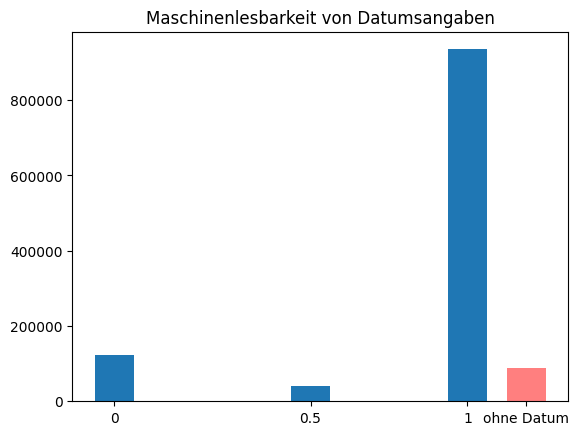

In [63]:
rows = cur.execute("SELECT DATECOV FROM analysis;").fetchall()

fig, ax = plt.subplots(1)
plt.hist([r[0] for r in rows if r[0] is not None])
c = Counter([r[0] for r in rows]).get(None)

ax.bar([1.1],[c],width=0.1, color='red', alpha=0.5)
ax.set_xticks([0.05,0.55,0.95,1.1], labels = ["0","0.5","1","ohne Datum"])
ax.ticklabel_format(axis = 'y', style = 'scientific')


plt.title("Maschinenlesbarkeit von Datumsangaben")

plt.savefig('date.png', dpi = 200)

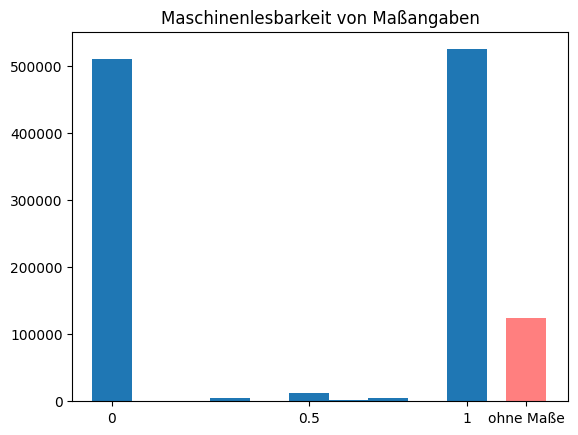

In [65]:
rows = cur.execute("SELECT MEASURECOV FROM analysis;").fetchall()

fig, ax = plt.subplots(1)
plt.hist([r[0] for r in rows if r[0] is not None])
c = Counter([r[0] for r in rows]).get(None)

ax.bar([1.1],[c],width=0.1, color='red', alpha=0.5)
ax.set_xticks([0.05,0.55,0.95,1.1], labels = ["0","0.5","1","ohne Maße"])
ax.ticklabel_format(axis = 'y', style = 'scientific')
ax.set_xlim(left=-0.05)
plt.title("Maschinenlesbarkeit von Maßangaben")

plt.savefig('measurements.png', dpi = 200)